# OOI Lab Manual: Lab 6 Ocean Physics

This notebook demonstrates how to access and process the dataset used in *Lab 6 Ocean Physics* of the [2021 OOI Lab Manual](https://datalab.marine.rutgers.edu/ooi-lab-exercises/).

It is based on an [earlier Air Sea interactions notebook](https://github.com/ooi-data-lab/data-lab-workshops/blob/master/June2019/DL_June_Air_Sea_v1.ipynb) created as part of the 2019 OOI Data Lab workshop series.

By Sage Lichtenwalner, Revised June 24, 2021

In [1]:
# Notebook Setup
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# # Setup default plot styles
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# !pip install git+https://github.com/seagrinch/ooilab.git
import ooilab
ooilab.API_USERNAME = ''
ooilab.API_TOKEN = ''

## Request Data - January 2018 (1st week)

In [3]:
# Wave Data
# ooilab.request_data('CP01CNSM-SBD12-05-WAVSSA000','recovered_host','wavss_a_dcl_statistics_recovered',
#              '2018-01-01T00:00:00.000Z','2018-01-07T00:00:00.000Z')
# Met Data
# ooilab.request_data('CP01CNSM-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered',
#              '2018-01-01T00:00:00.000Z','2018-01-07T00:00:00.000Z')

## Load Data Files

In [4]:
url_wave = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20210624T200304442Z-CP01CNSM-SBD12-05-WAVSSA000-recovered_host-wavss_a_dcl_statistics_recovered/catalog.html'
url_met = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20210624T200315042Z-CP01CNSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'

In [5]:
# Load the datasets
data_wave = xr.open_mfdataset(ooilab.get_filelist(url_wave)).swap_dims({'obs': 'time'}).sortby('time')
data_met = xr.open_mfdataset(ooilab.get_filelist(url_met)).swap_dims({'obs': 'time'}).sortby('time')

## Data Plots

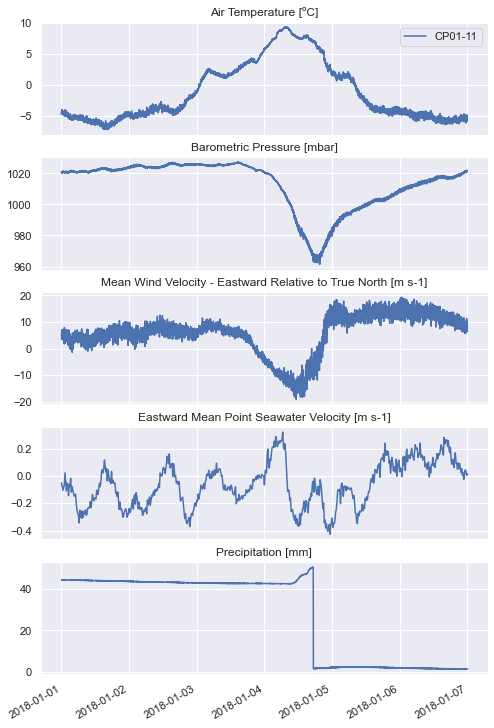

In [6]:
# Let's quickly plot the various METBK options
vars = ['air_temperature','barometric_pressure','met_windavg_mag_corr_east','eastward_velocity','precipitation']

fig,ax = plt.subplots(5,1,sharex=True,figsize=(8,12))
for i,var in enumerate(vars):
  data_met[var].plot(label='CP01-11',ax=ax[i])
  ax[i].set_xlabel('')
  ax[i].set_ylabel('')
  ax[i].set_title('%s [%s]' % (data_met[var].long_name,data_met[var].units));

ax[0].legend()

plt.savefig('airsea_2018_met.png')

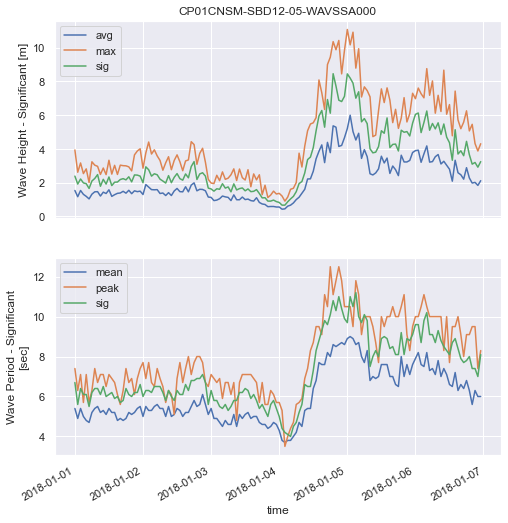

In [7]:
# And the WAVES variables
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(8,8))
data_wave.average_wave_height.plot(label='avg',ax=ax1)
data_wave.max_wave_height.plot(label='max',ax=ax1)
data_wave.significant_wave_height.plot(label='sig',ax=ax1)

data_wave.mean_wave_period.plot(label='mean',ax=ax2)
data_wave.peak_wave_period.plot(label='peak',ax=ax2)
data_wave.significant_period.plot(label='sig',ax=ax2)

ax1.set_xlabel('')
ax1.legend()
ax2.legend()
ax1.set_title('%s-%s-%s' % (data_wave.subsite,data_wave.node,data_wave.sensor));

plt.savefig('airsea_2018_waves.png')

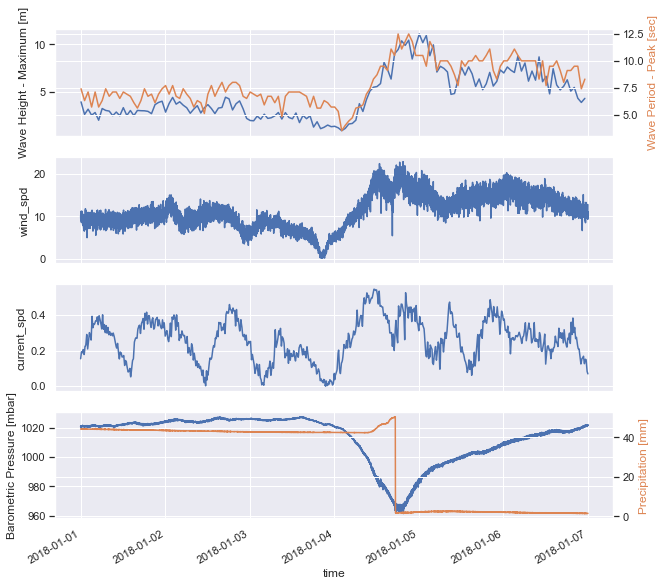

In [8]:
# Plot the data for the activity
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,9))
ax1b = ax1.twinx()
ax4b = ax4.twinx()
altcolor = sns.color_palette()[1]

data_wave.max_wave_height.plot(label='max', ax=ax1)
data_wave.peak_wave_period.plot(label='peak', ax=ax1b, color=altcolor)
ax1b.set_ylabel(ax1b.yaxis.label.get_text() ,color=altcolor)

data_met['wind_spd'] = (data_met.met_windavg_mag_corr_east**2 + data_met.met_windavg_mag_corr_north**2)**0.5
data_met.wind_spd.plot(ax=ax2)

data_met['current_spd'] = (data_met.eastward_velocity**2 + data_met.northward_velocity**2)**0.5
data_met['current_spd'].plot(ax=ax3)

data_met.barometric_pressure.plot(ax=ax4)
data_met.precipitation.plot(ax=ax4b, color=altcolor)
ax4b.set_ylabel(ax4b.yaxis.label.get_text(), color=altcolor)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('');

plt.savefig("airsea_2018_raw.png");

## 3. Merge and export

In [9]:
# Subset the datasets
a = data_met[['wind_spd','current_spd','barometric_pressure','precipitation','air_temperature']]
b = data_wave[['max_wave_height','peak_wave_period','significant_wave_height','significant_period']]

# Resample/average
avgint = '1h' #'15min'
a_avg = a.load().resample(time=avgint).mean()
b_avg = b.load().resample(time=avgint).mean()

# Calculate Daily Precipitation 
rain = data_met.precipitation.load().resample(time='15min').mean().diff('time')
rain = rain.where(rain>0)
rain = rain.resample(time=avgint).sum()
rain = rain.where(rain<100)
a_avg['rain'] = rain


In [10]:
# Merge the datasets
x = xr.merge([a_avg,b_avg]).to_dataframe()

# Print the first few rows
# x.head()

In [11]:
# Export to CSV
x.to_csv('airsea_2018.csv')

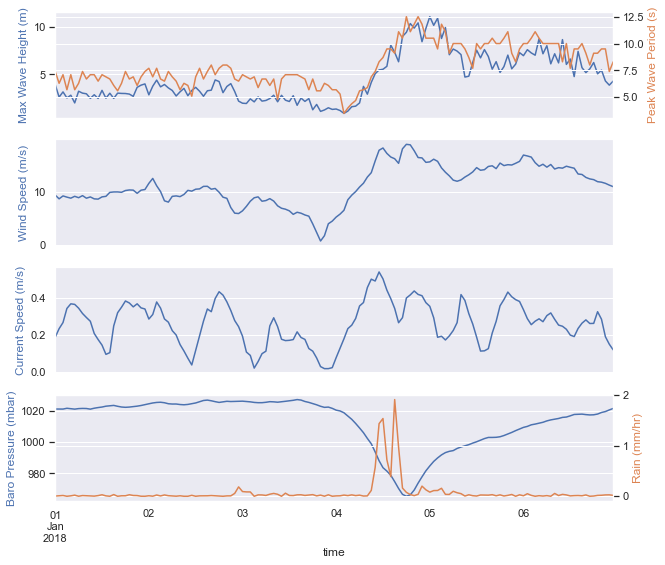

In [12]:
# Final plot
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,9))
ax1b = ax1.twinx()
ax4b = ax4.twinx()
color1 = sns.color_palette()[0]
color2 = sns.color_palette()[1]

x.max_wave_height.plot(label='max', ax=ax1)
x.peak_wave_period.plot(label='peak', ax=ax1b, color=color2)
x.wind_spd.plot(ax=ax2)
x.current_spd.plot(ax=ax3)
x.barometric_pressure.plot(ax=ax4)
x.rain.plot(ax=ax4b, color=color2)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('');

ax1.set_ylabel('Max Wave Height (m)',color=color1)
ax1b.set_ylabel('Peak Wave Period (s)',color=color2)
ax2.set_ylabel('Wind Speed (m/s)', color=color1)
ax3.set_ylabel('Current Speed (m/s)', color=color1)
ax4.set_ylabel('Baro Pressure (mbar)', color=color1)
ax4b.set_ylabel('Rain (mm/hr)',color=color2)

plt.savefig("airsea_2018_final.png");

## Second Dataset - February 2019

In [13]:
# Wave Data
# ooilab.request_data('CP01CNSM-SBD12-05-WAVSSA000','recovered_host','wavss_a_dcl_statistics_recovered',
#              '2019-02-01T00:00:00.000Z','2019-03-01T00:00:00.000Z')
# Met Data
# ooilab.request_data('CP01CNSM-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered',
#              '2019-02-01T00:00:00.000Z','2019-03-01T00:00:00.000Z')

In [14]:
url_wave = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20210624T201546032Z-CP01CNSM-SBD12-05-WAVSSA000-recovered_host-wavss_a_dcl_statistics_recovered/catalog.html'
url_met = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20210624T201607961Z-CP01CNSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'

In [15]:
# Load the datasets
data_wave = xr.open_mfdataset(ooilab.get_filelist(url_wave)).swap_dims({'obs': 'time'}).sortby('time')
data_met = xr.open_mfdataset(ooilab.get_filelist(url_met)).swap_dims({'obs': 'time'}).sortby('time')

# Calculate Wind Speed
data_met['wind_spd'] = (data_met.met_windavg_mag_corr_east**2 + data_met.met_windavg_mag_corr_north**2)**0.5
# Calculate Current Speed
data_met['current_spd'] = (data_met.eastward_velocity**2 + data_met.northward_velocity**2)**0.5

In [16]:
# Subset the datasets
a = data_met[['wind_spd','current_spd','barometric_pressure','precipitation','air_temperature']]
b = data_wave[['max_wave_height','peak_wave_period','significant_wave_height','significant_period']]

# Resample/average
avgint = '1h' #'15min'
a_avg = a.load().resample(time=avgint).mean()
b_avg = b.load().resample(time=avgint).mean()

# Calculate Daily Precipitation 
rain = data_met.precipitation.load().resample(time='15min').mean().diff('time')
rain = rain.where(rain>0)
rain = rain.resample(time=avgint).sum()
rain = rain.where(rain<100)
a_avg['rain'] = rain

In [17]:
# Merge the datasets
x = xr.merge([a_avg,b_avg]).to_dataframe()

# Export to CSV
x.to_csv('airsea_2019.csv')

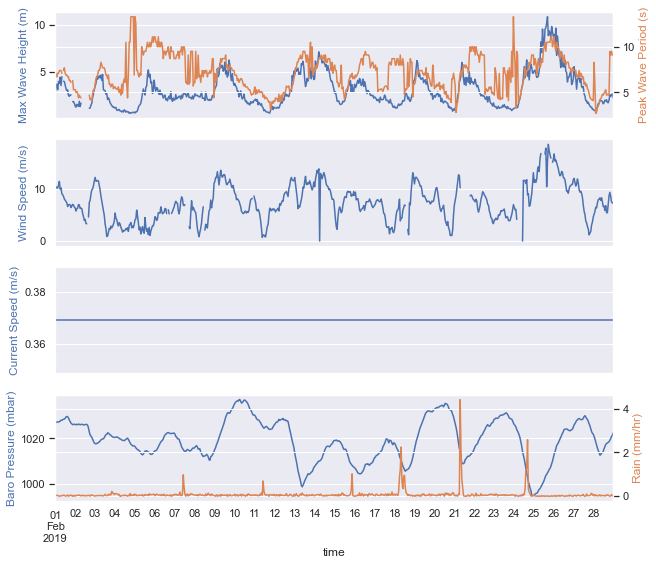

In [18]:
# Final plot
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,9))
ax1b = ax1.twinx()
ax4b = ax4.twinx()
color1 = sns.color_palette()[0]
color2 = sns.color_palette()[1]

x.max_wave_height.plot(label='max', ax=ax1)
x.peak_wave_period.plot(label='peak', ax=ax1b, color=color2)
x.wind_spd.plot(ax=ax2)
x.current_spd.plot(ax=ax3)
x.barometric_pressure.plot(ax=ax4)
x.rain.plot(ax=ax4b, color=color2)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('');

ax1.set_ylabel('Max Wave Height (m)',color=color1)
ax1b.set_ylabel('Peak Wave Period (s)',color=color2)
ax2.set_ylabel('Wind Speed (m/s)', color=color1)
ax3.set_ylabel('Current Speed (m/s)', color=color1)
ax4.set_ylabel('Baro Pressure (mbar)', color=color1)
ax4b.set_ylabel('Rain (mm/hr)',color=color2)

plt.savefig("airsea_2019_final.png");

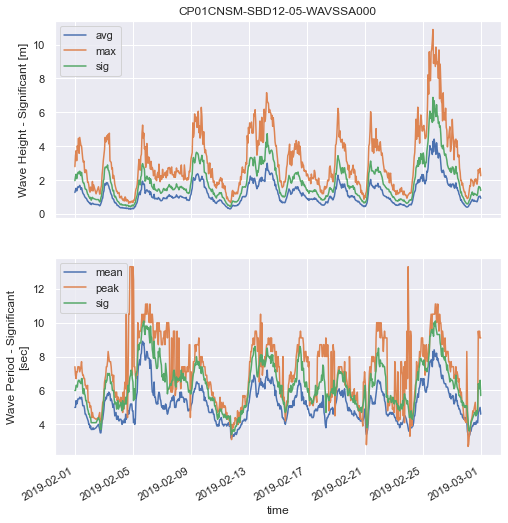

In [19]:
# And the WAVES variables
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(8,8))
data_wave.average_wave_height.plot(label='avg',ax=ax1)
data_wave.max_wave_height.plot(label='max',ax=ax1)
data_wave.significant_wave_height.plot(label='sig',ax=ax1)

data_wave.mean_wave_period.plot(label='mean',ax=ax2)
data_wave.peak_wave_period.plot(label='peak',ax=ax2)
data_wave.significant_period.plot(label='sig',ax=ax2)

ax1.set_xlabel('')
ax1.legend()
ax2.legend()
ax1.set_title('%s-%s-%s' % (data_wave.subsite,data_wave.node,data_wave.sensor));

plt.savefig('airsea_2019_waves.png')